# Baseline
We trained a simple, one layer RNN featuring LSTM units and a pretrained word embedding layer. The model was trained on 5 epochs and had the following metrics:

**Train average AUROC:** 0.984

**Validation average AUROC:** 0.98

**Test average AUROC:** 0.968

In [1]:
import json
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tf-related
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant

In [2]:
# execution hyperparameters
MAX_WORDS = 20000
VALIDATION_SPLIT = .2
EMBEDDING_DIM = 100
glove_path = "../glove.6B/glove.6B.100d.txt" # file name specifies dimension of embedding space
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1
corpus = []

## Tokenization and sequence formation

In [3]:
# obtain training 'labels' and 'sentences'
train = pd.read_csv("../data/train.csv")
labels = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values.tolist()
labels = np.array(labels)
sentences = train["comment_text"].values.tolist()

In [4]:
# word tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print("Words in training set: "+str(len(word_index)))

Words in training set: 210337


We observe that the training set actually has many more unique tokens than the number of words we will admit for computational reasons. This calls for further investigation. Let's look at the sentences' length distribution to decide on a reasonable maximum length.

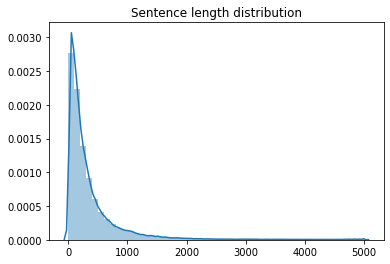

In [5]:
sentence_lengths = pd.Series([len(s) for s in sentences])
sns.distplot(sentence_lengths)
plt.title("Sentence length distribution");

In [6]:
sentence_lengths.describe(percentiles=[.1*i for i in range(10)])

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
0%            6.000000
10%          47.000000
20%          78.000000
30.0%       114.000000
40%         155.000000
50%         205.000000
60.0%       274.000000
70%         367.000000
80%         528.000000
90%         889.000000
max        5000.000000
dtype: float64

In [7]:
# cutting around the 90th percentile seems reasonable given the distribution's long tail
MAX_SEQ_LENGTH = 1000

In [8]:
# make the sequences uniform to pass them to a network
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)

## Data split

In [9]:
# split the data into a training set and a validation set
indices = np.arange(padded.shape[0])
np.random.shuffle(indices)
padded = padded[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * padded.shape[0])

x_train = padded[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = padded[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

## Transfer learning
We followed [this tutorial from the Keras documentation](https://keras.io/examples/pretrained_word_embeddings/) to implement transfer learning of a pretrained GloVe embedding. The training data for the embedding consists of messages from a forum-like network termed 'netnews'.

In [10]:
# load pretrained embedding matrix (implemented as an index for memory efficiency)
embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [11]:
# prepare embedding matrix
num_words = min(MAX_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQ_LENGTH,
                            trainable=False)

## RNN training

In [12]:
# Keras-ready average AUROC
from avg_auroc import AvgAurocCallback, avg_auroc_metric
avg_auroc_callback = AvgAurocCallback(x_train, y_train, x_val, y_val)

In [13]:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         2000100   
_________________________________________________________________
dropout (Dropout)            (None, 1000, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 249, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 2,065,578
Trainable params: 65,478
Non-trainable params: 2,000,100
_____________________________________________________________

In [15]:
num_epochs = 5
history = model.fit(x_train, y_train, epochs=num_epochs, verbose=1, batch_size=128, validation_data=(x_val, y_val),
                   callbacks=[avg_auroc_callback])

Train on 127657 samples, validate on 31914 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
127616/127657 [============================>.] - ETA: 0s - loss: 0.0839
Train avg_auroc: 0.967, Val avg_auroc: 0.966
127657/127657 [==============================] - 955s 7ms/sample - loss: 0.0839 - val_loss: 0.0585
Epoch 2/5
127616/127657 [============================>.] - ETA: 0s - loss: 0.0591
Train avg_auroc: 0.973, Val avg_auroc: 0.973
127657/127657 [==============================] - 986s 8ms/sample - loss: 0.0591 - val_loss: 0.0536
Epoch 3/5
127616/127657 [============================>.] - ETA: 0s - loss: 0.0567
Train avg_auroc: 0.975, Val avg_auroc: 0.974
127657/127657 [==============================] - 984s 8ms/sample - loss: 0.0567 - val_loss: 0.0538
Epoch 4/5
127616/127657 [============================>.] - ETA: 0s - loss: 0.0529
Train avg_auroc: 0.981, Val avg_auroc: 0.978
127657/127657 [==============================] - 993s 8ms/sample - loss: 0.0529 - val_loss: 0.05

## Make a submission

In [28]:
test = pd.read_csv("data/test.csv")
test_sentences = test.pop("comment_text").values.tolist()

In [19]:
# make the sequences uniform to pass them to a network
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQ_LENGTH)

In [20]:
# make predictions
y_test_hat = model.predict(test_padded)

In [33]:
# write submission file
y_test_hat = pd.DataFrame(data=y_test_hat, columns=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
test = test.join(y_test_hat)
test.to_csv("../submissions/baseline_submission.csv", index=False)

## Store results
We'll store the final `History` object to make graphs and the model weights to further train this model, as the small difference between training and validation performance tells us it hasn't reached its full potential.

In [39]:
import pickle

In [38]:
hist_file = open("../models/baseline_history", "wb")
pickle.dump(history.history, hist_file)
hist_file.close()

In [40]:
model_json = model.to_json()
with open("../models/baseline_model.json", 'w') as json_file:
    json_file.write(model_json)
model.save_weights("../models/baseline_weights.h5")